# SWAN Project - Team Izzy and her Boys - By Izzy, Ashley and Bekim

## Table of Contents

[Introduction](#1)    <img src="https://github.com/izzybenson03/SWAN-project/blob/main/swan.png?raw=true" width="300" height="150" align="right">  
[Loading in Data](#2)    
[Exploratory Data Analysis (EDA)](#3)    
[Logistic regression](#4)  
[Decision Trees and Random Forest](#5)  
[Conclusion](#6) 

## Introduction <a id="1"></a>

It is essential to minimise the risk of churners to increase customer retention and ensure the long-term growth of Swan Teleco's customer base.

> This notebook explores your data to investigate the characteristics of churners, and includes both a **logistic regression** and a **random forest** analysis to predict the risk of existing customers becoming churners.

## Loading in Data <a id="2"></a>

In [37]:
import numpy as np
import pandas as pd

from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn import tree, metrics
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import GridSearchCV, KFold
from sklearn.metrics import confusion_matrix, accuracy_score, mean_squared_error, r2_score
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier, BaggingClassifier
from sklearn.preprocessing import RobustScaler
from statsmodels.stats.outliers_influence import variance_inflation_factor
import statsmodels.api as sm
import statsmodels.tools

import seaborn as sns
import matplotlib.pyplot as plt

In [3]:
# Read the csv file into a DataFrame
df = pd.read_csv('./SWAN project data.csv')

# Get an overview of the dataframe
df.head(3)

,CustomerID,Count,Country,State,City,Zip Code,Lat Long,Latitude,Longitude,Gender,...,Streaming TV,Streaming Movies,Contract,Paperless Billing,Payment Method,Monthly Charges,Total Charges,Churn Label,Churn Value,Churn Reason
0,3668-QPYBK,1,United States,California,Los Angeles,90003,"33.964131, -118.272783",33.964131,-118.272783,Male,...,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,Yes,1,Competitor made better offer
1,9237-HQITU,1,United States,California,Los Angeles,90005,"34.059281, -118.30742",34.059281,-118.307420,Female,...,No,No,Month-to-month,Yes,Electronic check,70.70,151.65,Yes,1,Moved
2,9305-CDSKC,1,United States,California,Los Angeles,90006,"34.048013, -118.293953",34.048013,-118.293953,Female,...,Yes,Yes,Month-to-month,Yes,Electronic check,99.65,820.5,Yes,1,Moved


## Exploratory Data Analysis (EDA) <a id="3"></a>

In [4]:
# Allow all columns to be seen
pd.set_option('display.max_columns', None)

In [5]:
# Checking data types & null values
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 31 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   CustomerID         7043 non-null   object 
 1   Count              7043 non-null   int64  
 2   Country            7043 non-null   object 
 3   State              7043 non-null   object 
 4   City               7043 non-null   object 
 5   Zip Code           7043 non-null   int64  
 6   Lat Long           7043 non-null   object 
 7   Latitude           7043 non-null   float64
 8   Longitude          7043 non-null   float64
 9   Gender             7043 non-null   object 
 10  Senior Citizen     7043 non-null   object 
 11  Partner            7043 non-null   object 
 12  Dependents         7043 non-null   object 
 13  Tenure Months      7043 non-null   int64  
 14  Phone Service      7043 non-null   object 
 15  Multiple Lines     7043 non-null   object 
 16  Internet Service   7043 

In [6]:
# Summary Statistics
df.describe()

,Count,Zip Code,Latitude,Longitude,Tenure Months,Monthly Charges,Churn Value
count,7043.0,7043.000000,7043.000000,7043.000000,7043.000000,7043.000000,7043.000000
mean,1.0,93521.964646,36.282441,-119.798880,32.371149,64.761692,0.265370
std,0.0,1865.794555,2.455723,2.157889,24.559481,30.090047,0.441561
min,1.0,90001.000000,32.555828,-124.301372,0.000000,18.250000,0.000000
25%,1.0,92102.000000,34.030915,-121.815412,9.000000,35.500000,0.000000
50%,1.0,93552.000000,36.391777,-119.730885,29.000000,70.350000,0.000000
75%,1.0,95351.000000,38.224869,-118.043237,55.000000,89.850000,1.000000
max,1.0,96161.000000,41.962127,-114.192901,72.000000,118.750000,1.000000


In [8]:
np.where(df['Total Charges']==' ') # Found non missing missing values

(array([2234, 2438, 2568, 2667, 2856, 4331, 4687, 5104, 5719, 6772, 6840]),)

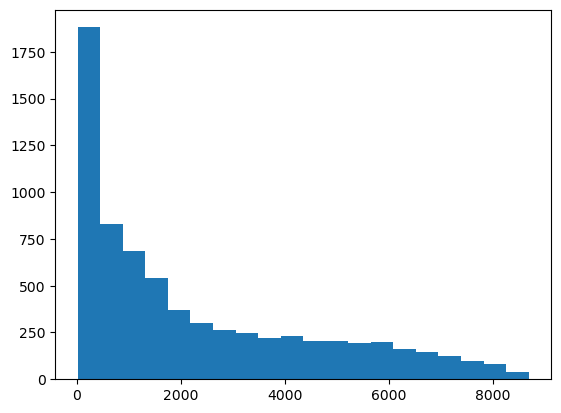

In [9]:
df1 = df.copy()
df1 = df1.drop([2234,2438,2568,2667,2856,4331,4687,5104,5719,6772,6840]) # Find the median, excluding blank rows
df1['Total Charges'] = df1['Total Charges'].astype('float')
charges_median = df1['Total Charges'].median()
plt.hist(df1['Total Charges'], bins=20);

In [10]:
# Feature Engineering Function
def feature_engineering(df):
    df_local = df.copy()
    
    # Mapping 
    df_local.Gender = df_local.Gender.map({'Male':1, 'Female':0}).astype('int')
    df_local['Senior Citizen'] = df_local['Senior Citizen'].map({'Yes':1,'No':0}).astype('int')
    df_local['Partner'] = df_local['Partner'].map({'Yes':1,'No':0}).astype('int')
    df_local['Dependents'] = df_local['Dependents'].map({'Yes':1,'No':0}).astype('int')
    df_local['Phone Service'] = df_local['Phone Service'].map({'Yes':1,'No':0}).astype('int')
    df_local['Paperless Billing'] = df_local['Paperless Billing'].map({'Yes':1, 'No':0})
    df_local['Churn Label'] = df['Churn Label'].map({'Yes':1, 'No':0})
    
    # OHE Columns
    df_local = pd.get_dummies(df_local, columns=['Multiple Lines'], prefix='Multiple Lines', dtype=int, drop_first=True)
    df_local = pd.get_dummies(df_local, columns=['Internet Service'], prefix='Internet Service', dtype=int, drop_first=True)
    df_local = pd.get_dummies(df_local, columns=['Online Security'], prefix='Online Security', dtype=int, drop_first=True)
    df_local = pd.get_dummies(df_local, columns=['Online Backup'], prefix='Online Backup', dtype=int, drop_first=True)
    df_local = pd.get_dummies(df_local, columns=['Device Protection'], prefix='Device Protection', dtype=int, drop_first=True)
    df_local = pd.get_dummies(df_local, columns=['Tech Support'], prefix='Tech Support', dtype=int, drop_first=True)
    df_local = pd.get_dummies(df_local, columns=['Streaming TV'], prefix='Streaming TV', dtype=int, drop_first=True)
    df_local = pd.get_dummies(df_local, columns=['Streaming Movies'], prefix='Streaming Movies', dtype=int, drop_first=True)
    df_local = pd.get_dummies(df_local, columns=['Contract'], prefix='Contract', dtype=int, drop_first=True)
    df_local = pd.get_dummies(df_local, columns=['Payment Method'], prefix='Payment Method', dtype=int, drop_first=True)

    # Filling empty strings with median value in 'Total Charges' column
    df_local['Total Charges'] = df_local['Total Charges'].replace(' ',1397.475).astype('float')

    # Dropping columns, which won't be needed in the model
    df_local = df_local.drop(columns = ['CustomerID','Count', 'Country','State','City','Zip Code', 'Lat Long', 'Latitude', 'Longitude', 'Churn Label','Churn Reason'])
    return df_local

In [11]:
# Applying feature engineering function to the DataFrame
df_fe = feature_engineering(df)

In [12]:
# Reviewing df_fe
df_fe.head()

,Gender,Senior Citizen,Partner,Dependents,Tenure Months,Phone Service,Paperless Billing,Monthly Charges,Total Charges,Churn Value,Multiple Lines_No phone service,Multiple Lines_Yes,Internet Service_Fiber optic,Internet Service_No,Online Security_No internet service,Online Security_Yes,Online Backup_No internet service,Online Backup_Yes,Device Protection_No internet service,Device Protection_Yes,Tech Support_No internet service,Tech Support_Yes,Streaming TV_No internet service,Streaming TV_Yes,Streaming Movies_No internet service,Streaming Movies_Yes,Contract_One year,Contract_Two year,Payment Method_Credit card (automatic),Payment Method_Electronic check,Payment Method_Mailed check
0,1,0,0,0,2,1,1,53.85,108.15,1,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1
1,0,0,0,1,2,1,1,70.70,151.65,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0
2,0,0,0,1,8,1,1,99.65,820.50,1,0,1,1,0,0,0,0,0,0,1,0,0,0,1,0,1,0,0,0,1,0
3,0,0,1,1,28,1,1,104.80,3046.05,1,0,1,1,0,0,0,0,0,0,1,0,1,0,1,0,1,0,0,0,1,0
4,1,0,0,1,49,1,1,103.70,5036.30,1,0,1,1,0,0,0,0,1,0,1,0,0,0,1,0,1,0,0,0,0,0


In [13]:
# Checking data types to ensure function has been applied successfully
df_fe.dtypes

Gender                                      int64
Senior Citizen                              int64
Partner                                     int64
Dependents                                  int64
Tenure Months                               int64
Phone Service                               int64
Paperless Billing                           int64
Monthly Charges                           float64
Total Charges                             float64
Churn Value                                 int64
Multiple Lines_No phone service             int64
Multiple Lines_Yes                          int64
Internet Service_Fiber optic                int64
Internet Service_No                         int64
Online Security_No internet service         int64
Online Security_Yes                         int64
Online Backup_No internet service           int64
Online Backup_Yes                           int64
Device Protection_No internet service       int64
Device Protection_Yes                       int64


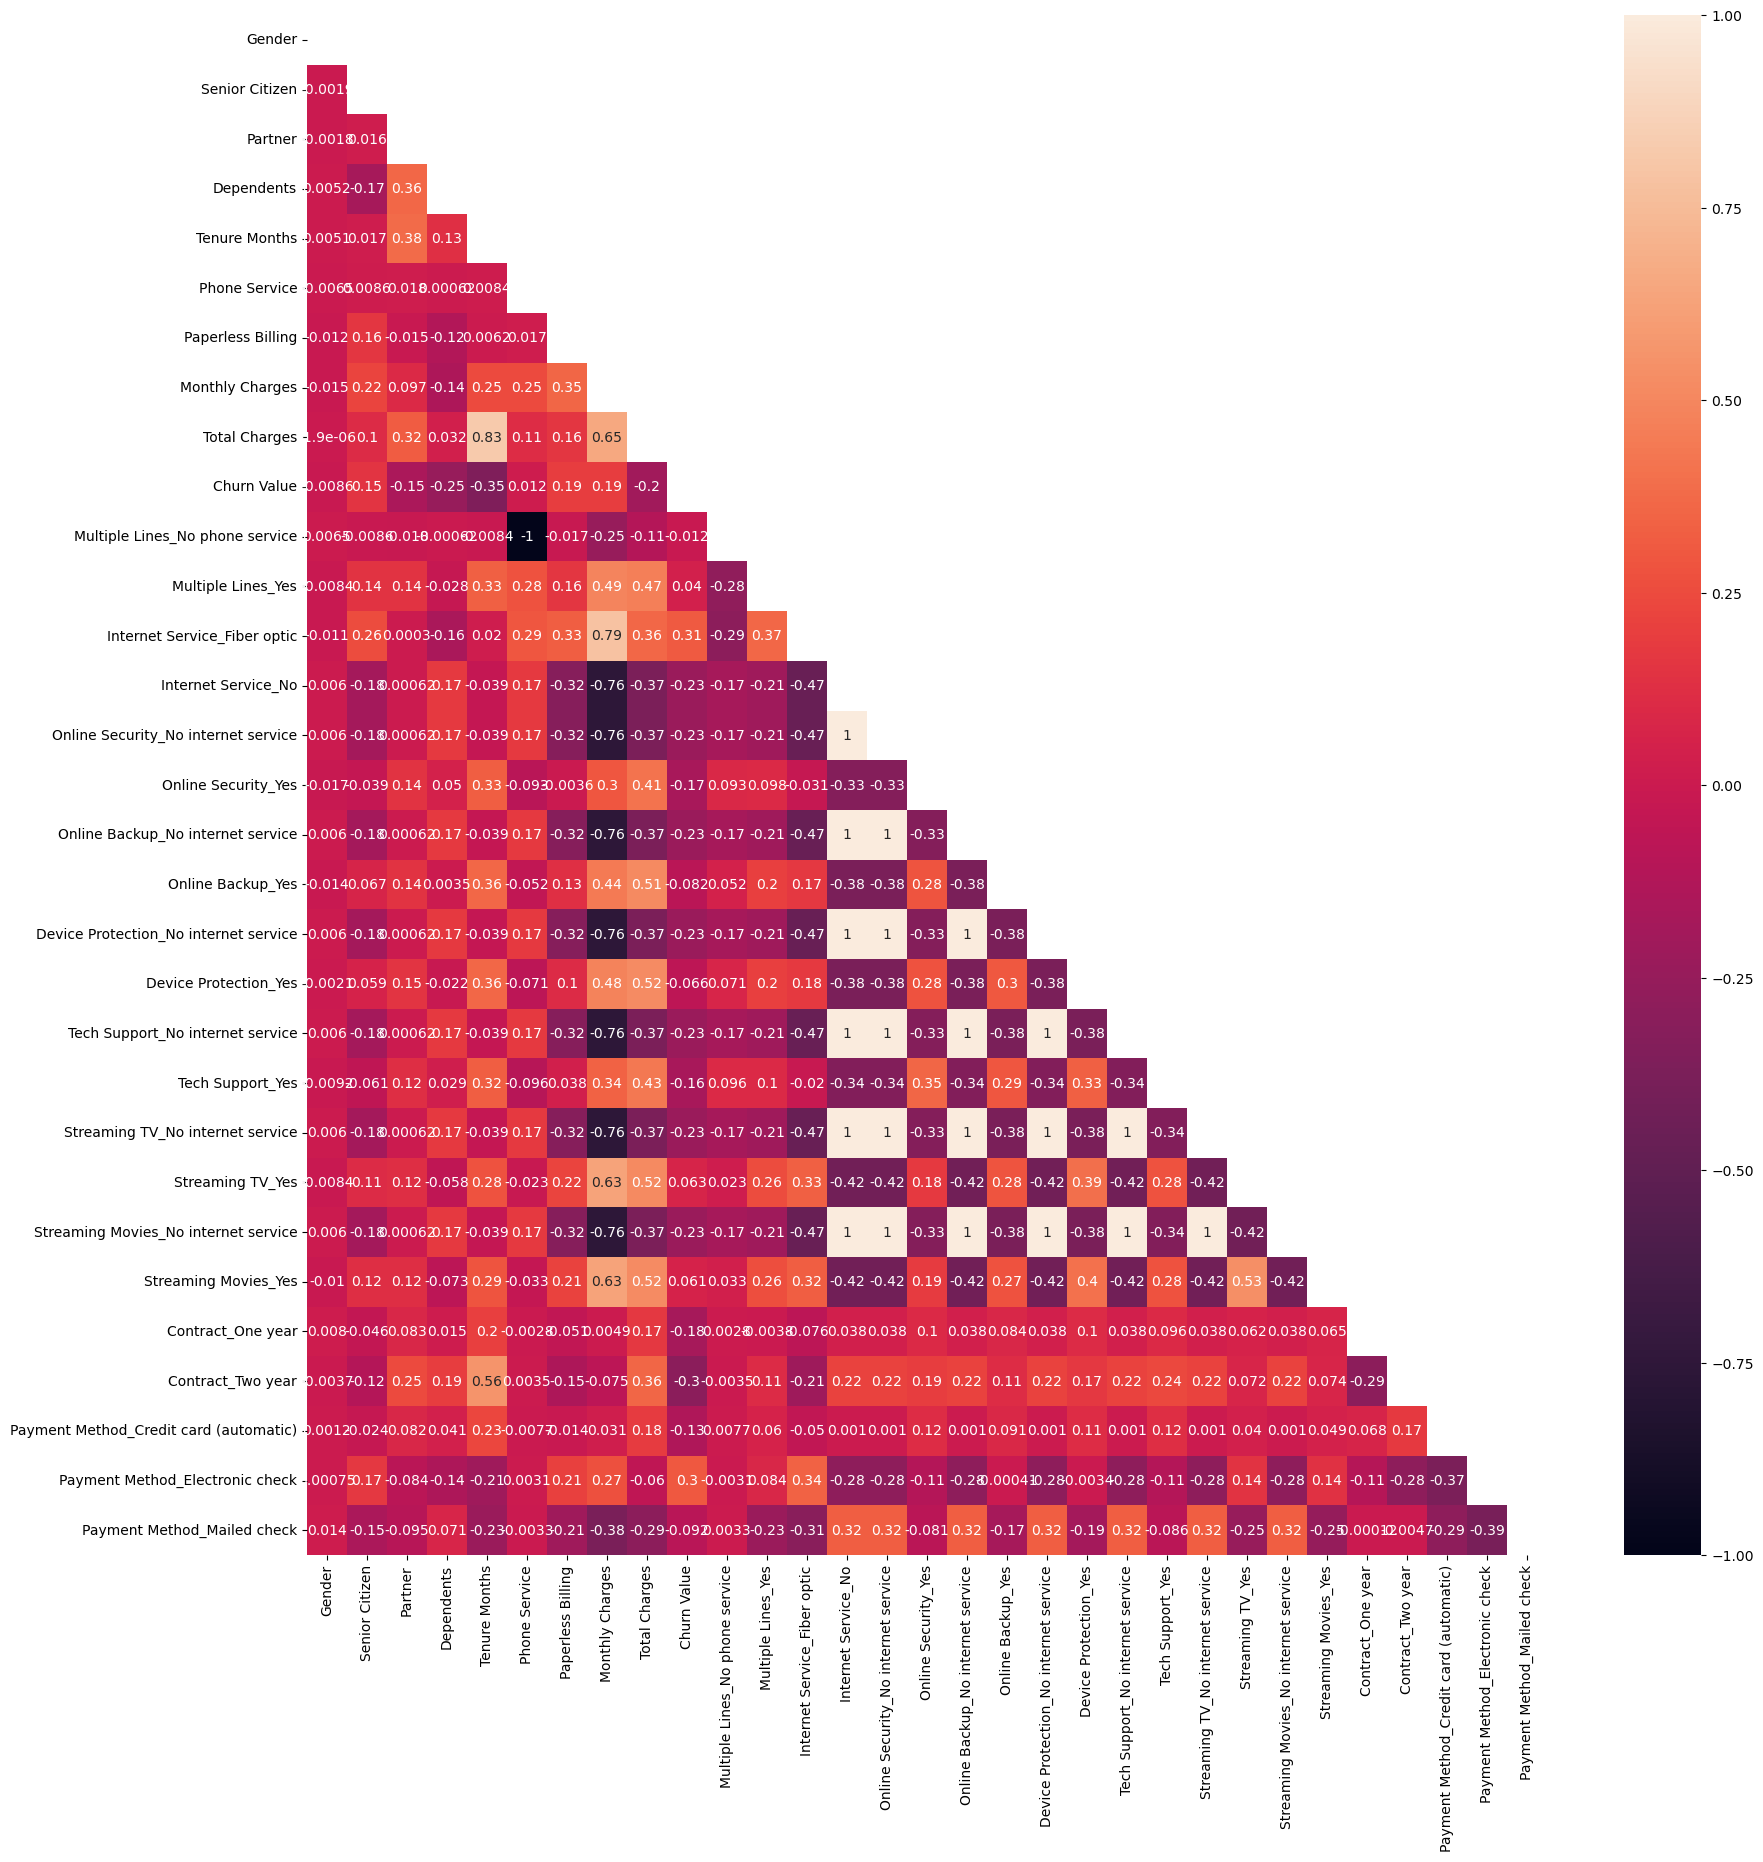

In [14]:
# Correlation heatmap of all features in df_fe
plt.figure(figsize=(20, 20))
sns.heatmap(df_fe.corr(numeric_only = True),
           mask = np.triu(df_fe.corr(numeric_only = True)),
           annot = True,
           vmin = -1,
           vmax = 1);

# Logistic Regression <a id="4"></a>

### Variance Inflation Factor (VIF)

First, we work out the **VIF** for our features, so we can drop columns which don't positively affect our model.

In [20]:
# VIF values of all features
features = df_fe.drop(columns = ['Churn Value'])
vif_data = pd.DataFrame()
vif_data['features1'] = features.columns
vif_data['VIF'] = [variance_inflation_factor(features.values, i)
                    for i in range(features.shape[1])]
vif_data.sort_values('VIF',ascending=False, inplace = True)
display(vif_data)


C:\Users\ashle\anaconda3\Lib\site-packages\statsmodels\stats\outliers_influence.py:197: RuntimeWarning: divide by zero encountered in scalar divide
  vif = 1. / (1. - r_squared_i)


,features1,VIF
13,Online Security_No internet service,inf
12,Internet Service_No,inf
19,Tech Support_No internet service,inf
21,Streaming TV_No internet service,inf
17,Device Protection_No internet service,inf
15,Online Backup_No internet service,inf
23,Streaming Movies_No internet service,inf
5,Phone Service,1770.976412
7,Monthly Charges,865.453457
11,Internet Service_Fiber optic,148.341146


We can see from this table that the features which inlude **'no internet service'** need to be dropped from the model. We can also see that there is seven other columns with a VIF **higher than 10**, which we consider to be our cut off and also remove these.

In [21]:
#Feature columns, dropping columns that have a high VIF value
X = df_fe.drop(columns = ['Churn Value', 'Multiple Lines_No phone service','Online Security_No internet service',
                          'Online Backup_No internet service','Device Protection_No internet service',
                          'Tech Support_No internet service','Streaming TV_No internet service',
                          'Streaming Movies_No internet service','Monthly Charges','Phone Service'])

In [22]:
# Target column
y = df_fe['Churn Value']

In [23]:
# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=.2, random_state=42)

In [24]:
# Initalising the model
lr = LogisticRegression(max_iter=10000, random_state=10)

In [25]:
# Fitting the model on train data
lr.fit(X_train, y_train)

LogisticRegression(max_iter=10000, random_state=10)

In [26]:
# Coefficients of all feature columns in the model
lr.coef_

array([[-3.82720964e-02,  1.19491515e-01,  2.53457761e-01,
        -1.42326749e+00, -5.94790531e-02,  3.92831574e-01,
         2.83190473e-04,  2.45473320e-01,  4.97001573e-01,
        -9.41886495e-01, -4.17059255e-01, -9.70790102e-02,
         2.24678724e-02, -3.69345415e-01,  2.04801229e-01,
         1.57781210e-01, -6.06931052e-01, -1.34388672e+00,
        -1.31653122e-01,  3.09714910e-01, -4.20844037e-02]])

In [27]:
# DataFrame of all coefficients and corresponding column names
pd.DataFrame({"Feature": X.columns.tolist(),"Coefficients":lr.coef_[0]}) 
#Source: https://stackoverflow.com/questions/48427922/how-to-print-the-column-names-along-with-the-column-co-efficients-for-logistic-r

,Feature,Coefficients
0,Gender,-0.038272
1,Senior Citizen,0.119492
2,Partner,0.253458
3,Dependents,-1.423267
4,Tenure Months,-0.059479
5,Paperless Billing,0.392832
6,Total Charges,0.000283
7,Multiple Lines_Yes,0.245473
8,Internet Service_Fiber optic,0.497002
9,Internet Service_No,-0.941886


We can now see the logistic regression **coefficients** for each feature we have included in our model. This shows us the features which have the biggest **influence** on whether customer churns with **Dependents** having the highest impact.

In [28]:
# Predicting on test data
X_test = X_test.copy()
X_test[['prob_nochurn', 'prob_churn']] = lr.predict_proba(X_test)
X_test['y_pred'] = np.where(X_test['prob_churn'] > 0.5, 1, 0)

In [29]:
# Predicting on train data
X_train = X_train.copy()
X_train[['prob_nochurn', 'prob_churn']] = lr.predict_proba(X_train)
X_train['y_pred'] = np.where(X_train['prob_churn'] > 0.5, 1, 0)

### Evaluating model performance

In [30]:
# Results function from DT & RF notebook
def get_results(actual, predicted):
    print(f'The accuracy of your model is: {metrics.accuracy_score(actual, predicted)}')
    print(f'The recall of your model is: {metrics.recall_score(actual, predicted)}')
    print(f'The precision of your model is: {metrics.precision_score(actual, predicted)}')
    print(f'The F1-score of your model is: {metrics.f1_score(actual, predicted)}')

In [31]:
# Applying function to test data
get_results(y_test, X_test['y_pred'])

The accuracy of your model is: 0.8034066713981547
The recall of your model is: 0.595
The precision of your model is: 0.6742209631728046
The F1-score of your model is: 0.6321381142098274


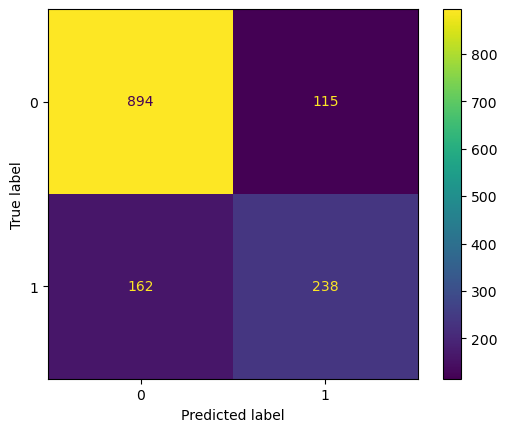

In [32]:
# Confusion matrix of test data
metrics.ConfusionMatrixDisplay(metrics.confusion_matrix(y_test, X_test['y_pred'])).plot()
plt.show()

### Exporting the most likely churners to CSV files

In [33]:
# Joining test and train data, and appending CustomerID
joined = X_test.copy()
joined = pd.concat([X_train,X_test])
joined['CustomerID'] = df['CustomerID']
joined['y']= y
joined.shape

(7043, 26)

In [34]:
# Getting Top 500 most likely churners into a CSV
nochurn = joined.loc[(joined['y']==0)]

# To save as a CSV, remove the comment from the line below
# nochurn[['CustomerID','prob_churn']].sort_values(by='prob_churn',ascending=False).head(500).to_csv('top500.csv',index=True)

In [37]:
# Getting the remaining customers into a CSV

# To save as a CSV, remove the comment from the line below
# nochurn[['CustomerID','prob_churn']].sort_values(by='prob_churn',ascending=False).tail(4674).to_csv('restofrisk.csv',index=True)

# Decision Trees + Random Forests <a id="5"></a>

## Initialising the model

In [35]:
# Creating a new train/test split for decision trees
X_train1, X_test1, y_train1, y_test1 = train_test_split(X,y, test_size = 0.3, random_state = 42)

In [ ]:
# initialising our model
tree = DecisionTreeClassifier(random_state=124)

# Untrained model into our cross validation
scores = cross_val_score(tree, X_train, y_train, cv = 5)

In [ ]:
## Functions from before

def apr(y_pred, y_real):
    accuracy = metrics.accuracy_score(y_real, y_pred)
    precision = metrics.precision_score(y_real, y_pred)
    recall = metrics.recall_score(y_real, y_pred)
    f1 = metrics.f1_score(y_real, y_pred)
    
    print(f"Accuracy:{accuracy}")
    print(f"Precision:{precision}")
    print(f"Recall:{recall}")
    print(f"F1:{f1}")
    return accuracy, precision, recall, f1


##

def produce_confusion(positive_label, negative_label, cut_off, df, y_pred_name, y_real_name):
    
    #Set pred to 0 or 1 depending on whether it's higher than the cut_off point.
    
    if cut_off != 'binary':      
        df['pred_binary'] = np.where(df[y_pred_name] > cut_off , 1, 0)
    else: 
        df['pred_binary'] = df[y_pred_name]
    
    #Build the CM
    cm = confusion_matrix(df[y_real_name], df['pred_binary'])  
    
    ax= plt.subplot()
    sns.heatmap(cm, annot=True, ax=ax, fmt='g'); 

    # labels, title, ticks
    ax.set_xlabel('Predicted labels');ax.set_ylabel('Real labels'); 
    ax.set_title('Confusion Matrix'); 
    ax.xaxis.set_ticklabels([negative_label, positive_label])
    ax.yaxis.set_ticklabels([negative_label, positive_label]);

    print('Test accuracy = ', accuracy_score(df[y_real_name], df['pred_binary']))

    return accuracy_score(df[y_real_name], df['pred_binary'])

In [ ]:
# an array of accuracies
scores

In [ ]:
# mean accuracy
sum(scores) / len(scores)

In [ ]:
predictions = pd.DataFrame(index=X_test.index)

In [ ]:
predictions.head()

In [ ]:
for i in range(10):
    dt = DecisionTreeClassifier()
    dt.fit(X_train, y_train)
    predictions[f'Tree {i}'] = dt.predict(X_test)

In [ ]:
X_train.shape[0]

In [ ]:
X_train.sample(n = 4930,
              replace = True
              )

In [ ]:
## ensemble method with random data

predictions = pd.DataFrame(index=X_test.index)

for i in range(10):
    new_x = X_train.sample(n = X_train.shape[0],replace = True)
    
    new_y = y_train[new_x.index]
      
    tree = DecisionTreeClassifier()
    tree.fit(new_x, new_y)
    predictions[f'Tree {i}'] = tree.predict(X_test)

In [ ]:
predictions['sum'] = predictions.sum(axis='columns')
predictions.value_counts()

In [ ]:
predictions['pred'] = predictions.mode(axis='columns')[0]

In [ ]:
apr(predictions['pred'], y_test)

In [ ]:
##

bag = BaggingClassifier(estimator=DecisionTreeClassifier())


##
bag.fit(X_train, y_train)

##
bag.score(X_test, y_test)

In [ ]:
bag.score(X_train, y_train)

## Bootstrapping <a id="6"></a>

In [ ]:
##

rf = RandomForestClassifier(n_estimators=50)
et = ExtraTreesClassifier(n_estimators=50)

In [ ]:
rf_score = cross_val_score(rf, X_train, y_train, cv=5)
et_score = cross_val_score(et, X_train, y_train, cv=5)

In [ ]:
print(f'Random scored {rf_score}')
print(f'Extra Random scored {et_score}')

In [ ]:
##

rf_params = {
    'n_estimators': [100, 150, 200],
    'max_depth': [None, 1, 2, 3, 4, 5],
}


gs = GridSearchCV(rf, param_grid=rf_params, cv=5)

gs.fit(X_train, y_train)

print(gs.best_score_)

gs.best_params_

In [ ]:
##

gs.score(X_train, y_train)

In [ ]:
y_train_pred = gs.best_estimator_.predict(X_train)
train_scores = apr(y_train_pred, y_train)

In [ ]:
y_test_pred = gs.best_estimator_.predict(X_test)
test_scores = apr(y_test_pred, y_test)

# Conclusion

* This workbook comprises the creation of a logistic regression model and a 